In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms

In [3]:
from sklearn.model_selection import train_test_split


In [4]:
torch.__version__

'1.11.0'

In [5]:
torch.cuda.set_per_process_memory_fraction(0.33, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            get_generator_block(64, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim*8, im_dim),
            nn.Sigmoid())


        
    def forward(self, noise):
        x = noise
        return self.gen(x)
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

In [7]:
def get_noise(n_samples, z_dim, device='cuda'):
    return torch.randn(n_samples, z_dim, device = device)

In [8]:
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace= True),
    )

class Discriminator(nn.Module):
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, image):
        x = image
        return  self.disc(image)
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc


In [9]:
n_epochs = 100
z_dim = 784
display_step = 50
batch_size = 128
lr = 0.00001
c_lambda = 10
crit_repeats = 5
device = 'cuda'

In [10]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,)),
# ])

dataset = (
    MNIST('.', download=False, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

torch.Size([28, 28])


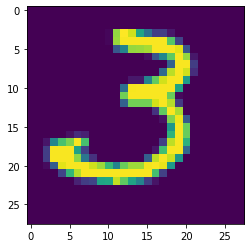

In [11]:
import time
for i in range(1):
    plt.ion()
    plt.figure()
    print(iter(dataset).next()[0][2][0].shape)
    plt.imshow(iter(dataset).next()[0][2][0])
    plt.show()

In [12]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [13]:
#load model
# gen.load_state_dict(torch.load(gen_path))
# disc.load_state_dict(torch.load(disc_path))

In [14]:
criterion = nn.BCEWithLogitsLoss()

In [15]:
# calculate discrimato loss
def disc_loss_fun(gen, disc, criterion, real, num_images, z_dim, device):
    fake_noise = get_noise(num_images, 64, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    loss = (disc_fake_loss + disc_real_loss) / 2
    return loss

In [16]:
#calculate generator loss
def gen_loss(gen, disc, criterion, num_images, z_dim, device):
    z_noise = get_noise(num_images, 64, device)
    fake_noise = gen(z_noise)
    fake_noise_prediction = disc(fake_noise)
    loss = criterion(fake_noise_prediction, torch.ones_like(fake_noise_prediction))
    return loss

In [17]:
(len(dataset))

469

In [18]:
from tqdm import tqdm

In [19]:
#Training the GAN
def Train(gen, disc, iterator, disc_optimizer, gen_optimizer, criterion):
    disc.train()
    gen.train()
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    for image, _ in tqdm((iterator), ncols = 75, desc ="Train", total = len(iterator)):
        b_size = len(image)
        real = image.view(b_size, -1).to(device)
        
        #generator

        gen_optimizer.zero_grad()
        gen_loss_1 = gen_loss(gen, disc, criterion, b_size, z_dim, device)
        gen_loss_1.backward()
        gen_optimizer.step()
        mean_generator_loss += gen_loss_1.item()/(len(iterator))
        
        #train disc
        disc_optimizer.zero_grad()
        disc_loss = disc_loss_fun(gen, disc, criterion, real, b_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        disc_optimizer.step()
        mean_discriminator_loss += disc_loss.item()/(len(iterator))
        
    return mean_discriminator_loss, mean_generator_loss

In [20]:
def generate_image(gan, num_images, z_dims, device = "cpu"):
    gen.eval()
    with torch.no_grad():
        noise = get_noise(num_images, z_dims, device)
        images = gan(noise)
    return images

def plot(images):
    image_datas = images.cpu()
    plt.ion()
    plt.figure()
    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(image_datas[0].view(-1,28))
    axarr[0,1].imshow(image_datas[1].view(-1,28))
    axarr[1,0].imshow(image_datas[2].view(-1,28))
    axarr[1,1].imshow(image_datas[3].view(-1,28))
    plt.show()

Epoch [0 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

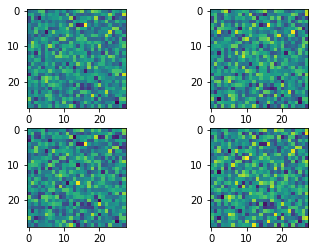

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:55<00:00,  8.51it/s]


discrimnator loss  0.41018243029173496
generator loss  1.405424171673464
Epoch [1 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

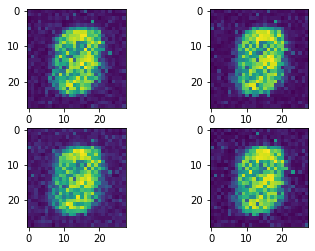

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:57<00:00,  8.21it/s]


discrimnator loss  0.400021737508936
generator loss  1.4431672833367466
Epoch [2 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

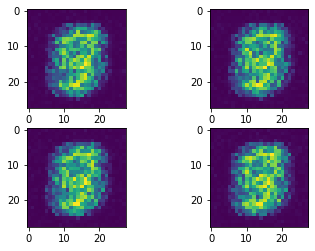

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:33<00:00, 14.14it/s]


discrimnator loss  0.35800958925218695
generator loss  1.3670089976873978
Epoch [3 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

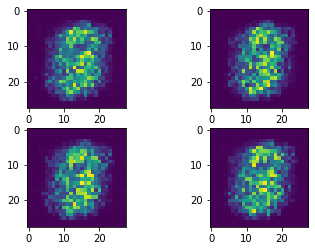

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:30<00:00, 15.15it/s]

discrimnator loss  0.36610788678817896
generator loss  1.1588527117965062
Epoch [4 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

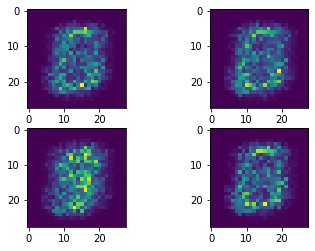

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.03it/s]


discrimnator loss  0.40518768973696184
generator loss  0.9481880861813067
Epoch [5 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

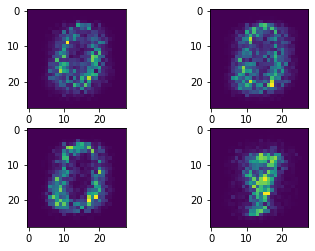

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.67it/s]

discrimnator loss  0.4027721011308213
generator loss  0.9063814372650342
Epoch [6 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

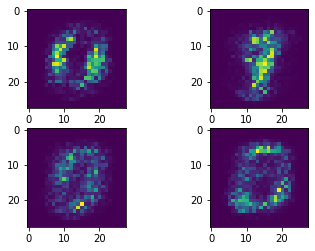

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.01it/s]

discrimnator loss  0.3635775593043899
generator loss  0.9851595686951167
Epoch [7 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

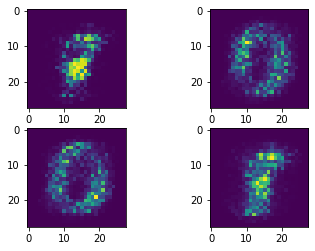

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.02it/s]

discrimnator loss  0.36473735957257575
generator loss  1.0327446305675543
Epoch [8 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

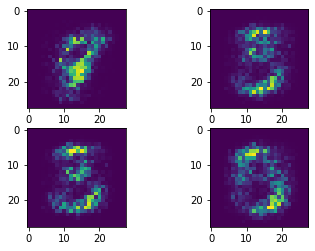

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.10it/s]


discrimnator loss  0.37527131958048476
generator loss  1.0649746575081018
Epoch [9 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

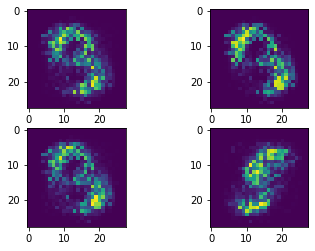

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.06it/s]


discrimnator loss  0.3497056541031101
generator loss  1.191401114087623
Epoch [10 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

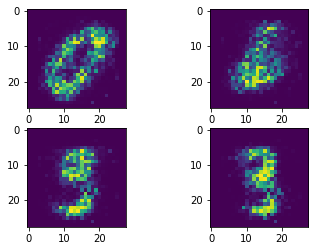

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.84it/s]


discrimnator loss  0.31010021050093284
generator loss  1.354984481705786
Epoch [11 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

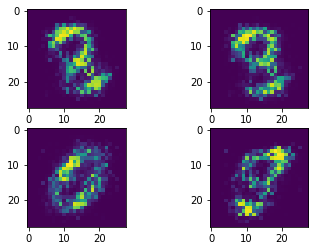

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.87it/s]


discrimnator loss  0.3256007804672346
generator loss  1.4124822880921832
Epoch [12 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

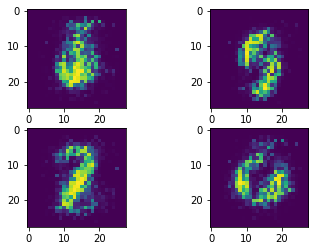

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.99it/s]


discrimnator loss  0.2923347839414437
generator loss  1.5312699478572367
Epoch [13 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

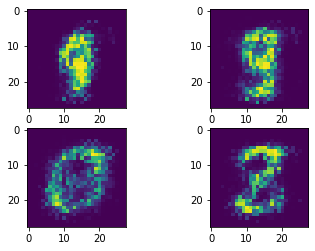

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.99it/s]

discrimnator loss  0.27873986009468665
generator loss  1.6333661305624776
Epoch [14 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

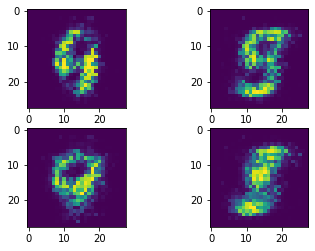

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.95it/s]


discrimnator loss  0.26456030094420213
generator loss  1.6392495774511084
Epoch [15 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

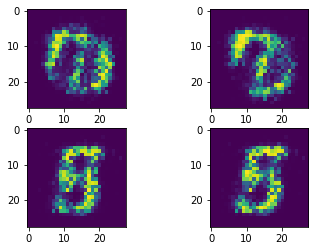

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:32<00:00, 14.58it/s]


discrimnator loss  0.2289034833214176
generator loss  1.7845616973539398
Epoch [16 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

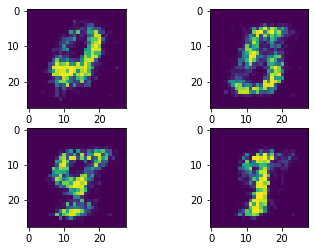

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.08it/s]


discrimnator loss  0.19769494422971567
generator loss  1.9034631750476896
Epoch [17 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

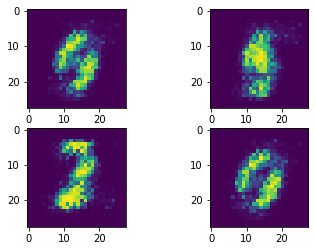

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:30<00:00, 15.26it/s]


discrimnator loss  0.212304773742456
generator loss  1.8666914490494382
Epoch [18 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

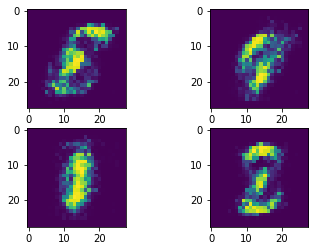

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:30<00:00, 15.17it/s]

discrimnator loss  0.20706774942529205
generator loss  1.8999586468820628
Epoch [19 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

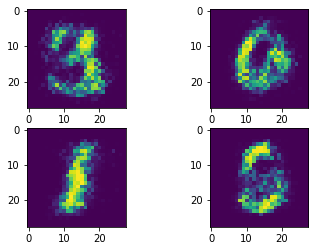

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:30<00:00, 15.14it/s]

discrimnator loss  0.21866249202538146
generator loss  1.8779701032618232
Epoch [20 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

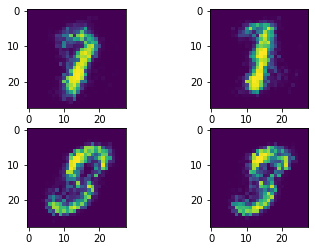

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:30<00:00, 15.18it/s]

discrimnator loss  0.19569685746993082
generator loss  1.9856311034546215
Epoch [21 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

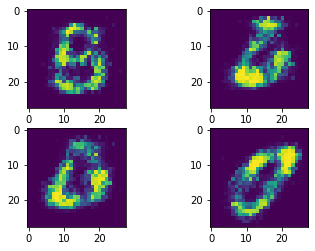

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.71it/s]

discrimnator loss  0.18507194897132143
generator loss  2.0819058245433166
Epoch [22 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

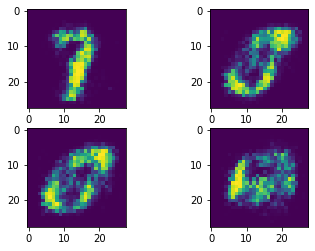

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.77it/s]


discrimnator loss  0.19250039581550962
generator loss  2.090084035005144
Epoch [23 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

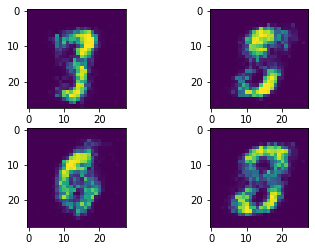

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.96it/s]


discrimnator loss  0.2005614899178305
generator loss  2.1063217745660965
Epoch [24 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

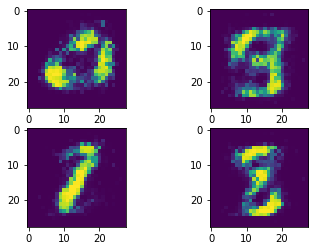

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.06it/s]

discrimnator loss  0.18999856561104603
generator loss  2.1263683048138513
Epoch [25 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

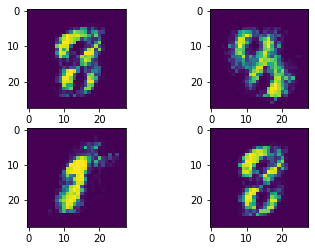

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.12it/s]

discrimnator loss  0.18392047219312013
generator loss  2.0996236302959383
Epoch [26 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

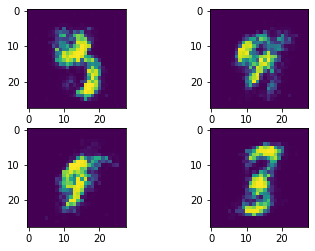

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.97it/s]


discrimnator loss  0.18434314026253076
generator loss  2.15951062977187
Epoch [27 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

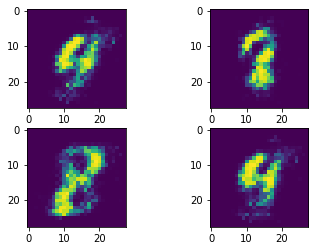

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.96it/s]

discrimnator loss  0.1710796791798016
generator loss  2.2171722683571047
Epoch [28 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

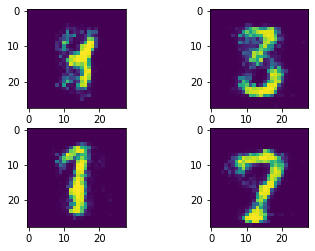

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.05it/s]

discrimnator loss  0.16583865201041137
generator loss  2.25169408295963
Epoch [29 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

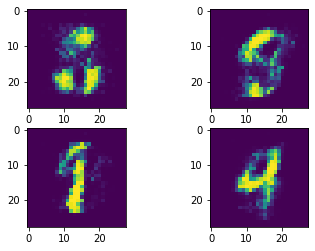

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.97it/s]


discrimnator loss  0.18240449493373628
generator loss  2.1948965060939667
Epoch [30 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

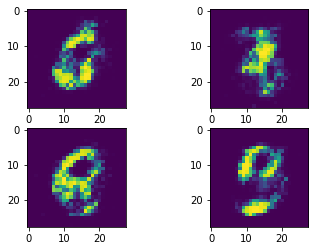

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.01it/s]

discrimnator loss  0.1872342890386644
generator loss  2.182727265459643
Epoch [31 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

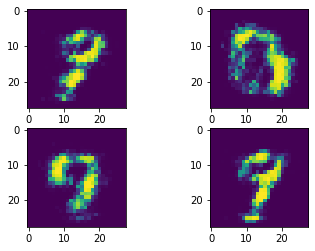

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.01it/s]


discrimnator loss  0.16686383522014378
generator loss  2.2437282538871526
Epoch [32 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

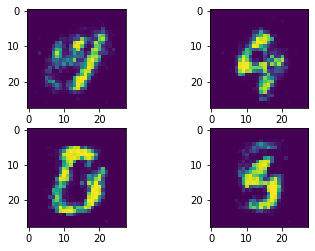

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.04it/s]

discrimnator loss  0.17135817524212513
generator loss  2.2727857200321626
Epoch [33 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

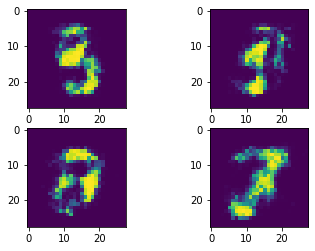

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.01it/s]

discrimnator loss  0.17527570338772824
generator loss  2.2720536418052606
Epoch [34 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

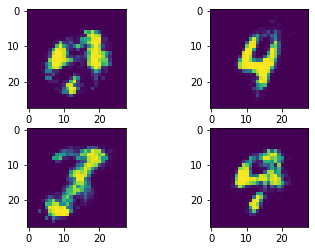

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.02it/s]

discrimnator loss  0.18349404305791564
generator loss  2.2936997881322037
Epoch [35 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

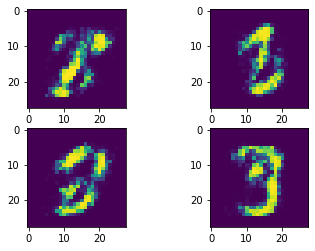

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.85it/s]


discrimnator loss  0.20936704847985488
generator loss  2.196439873180918
Epoch [36 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

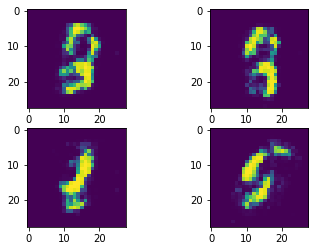

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.99it/s]


discrimnator loss  0.19975496755479996
generator loss  2.1943978076296324
Epoch [37 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

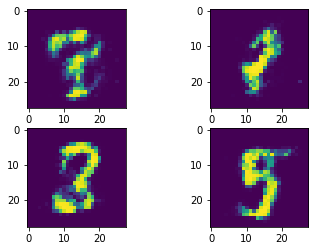

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.01it/s]

discrimnator loss  0.18327773421176713
generator loss  2.2837891868436784
Epoch [38 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

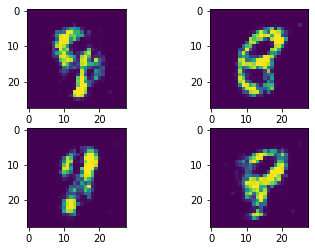

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.07it/s]


discrimnator loss  0.19383814409851766
generator loss  2.292706347477715
Epoch [39 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

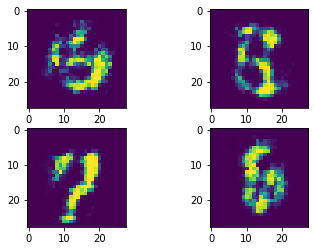

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.08it/s]


discrimnator loss  0.19781040611551762
generator loss  2.2332096097311727
Epoch [40 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

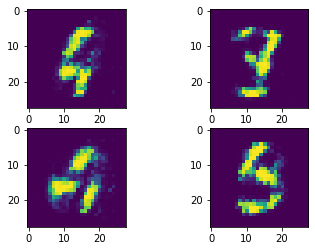

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.12it/s]

discrimnator loss  0.18872464694448102
generator loss  2.284987859380272
Epoch [41 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

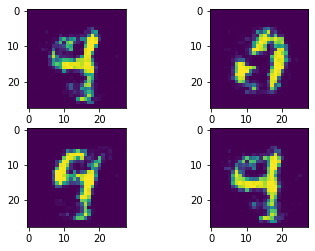

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.13it/s]


discrimnator loss  0.20505793567405334
generator loss  2.2336296389606227
Epoch [42 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

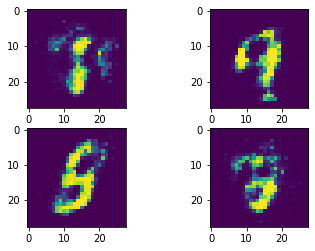

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.05it/s]

discrimnator loss  0.20402036944050778
generator loss  2.2360572835275607
Epoch [43 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

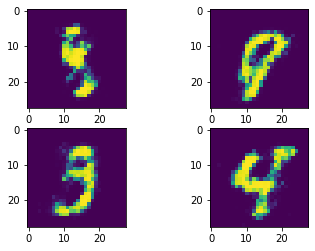

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.11it/s]

discrimnator loss  0.2075356140828081
generator loss  2.2203243709068055
Epoch [44 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

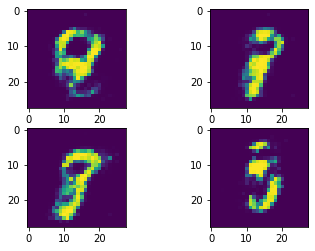

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.94it/s]


discrimnator loss  0.23296700065324022
generator loss  2.1249569682424276
Epoch [45 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

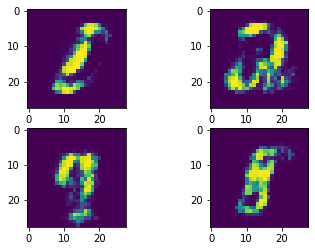

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.01it/s]

discrimnator loss  0.2267167242224028
generator loss  2.109427657462895
Epoch [46 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

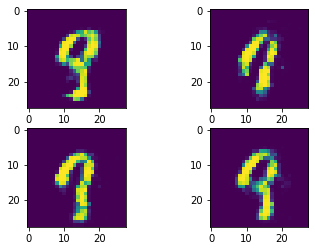

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.02it/s]


discrimnator loss  0.20639737239524483
generator loss  2.2672450483989124
Epoch [47 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

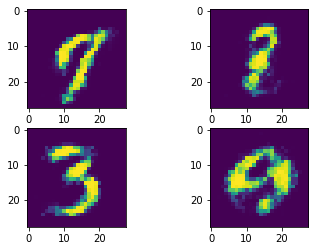

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.99it/s]


discrimnator loss  0.21272510874754336
generator loss  2.1889580035768845
Epoch [48 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

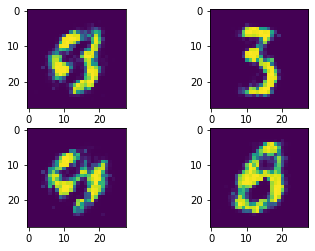

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.01it/s]

discrimnator loss  0.20803612372133012
generator loss  2.2419876086432304
Epoch [49 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

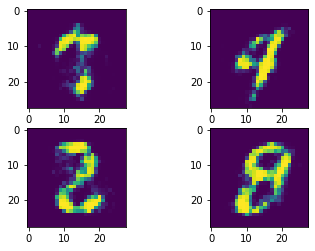

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.99it/s]


discrimnator loss  0.22918963232147152
generator loss  2.188849646399524
Epoch [50 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

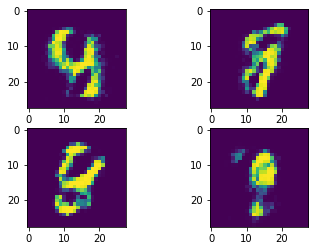

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.10it/s]

discrimnator loss  0.22745867365840142
generator loss  2.1745193370623896
Epoch [51 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

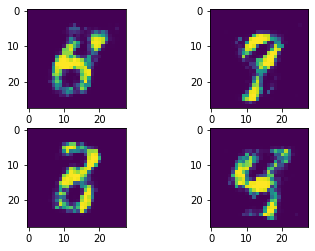

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.00it/s]


discrimnator loss  0.228739180830496
generator loss  2.1740271623200695
Epoch [52 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

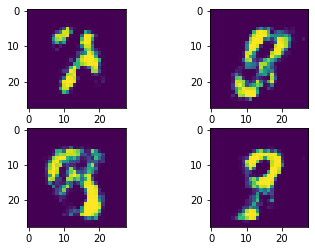

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.84it/s]

discrimnator loss  0.23313096181543144
generator loss  2.2166826191233184
Epoch [53 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

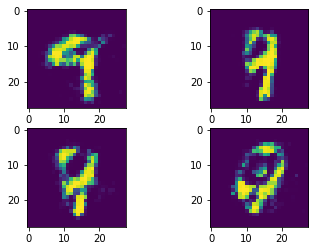

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.03it/s]


discrimnator loss  0.22474389636059053
generator loss  2.209283126188493
Epoch [54 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

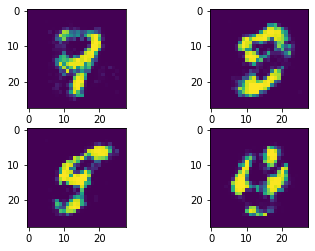

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.98it/s]

discrimnator loss  0.24630810339440665
generator loss  2.1287835483103668
Epoch [55 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

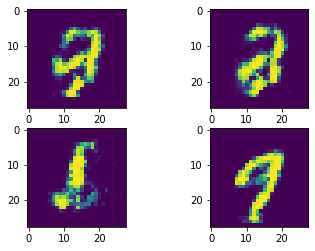

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.03it/s]

discrimnator loss  0.2253043619490889
generator loss  2.2045622494683355
Epoch [56 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

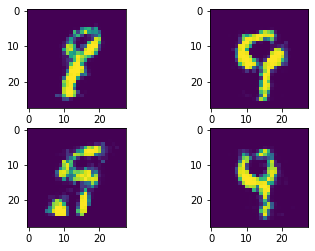

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.89it/s]


discrimnator loss  0.22906686019287437
generator loss  2.2021861254279274
Epoch [57 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

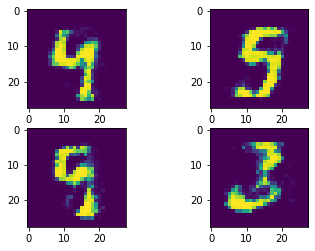

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.05it/s]

discrimnator loss  0.25201615192361493
generator loss  2.1644800316804527
Epoch [58 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

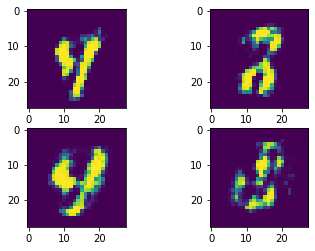

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.05it/s]


discrimnator loss  0.25884373508282554
generator loss  2.0453681991552743
Epoch [59 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

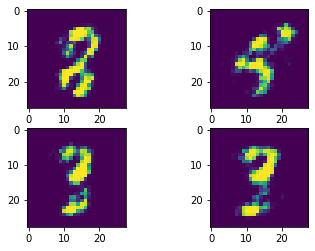

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.88it/s]


discrimnator loss  0.23403777518887509
generator loss  2.199582723920535
Epoch [60 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

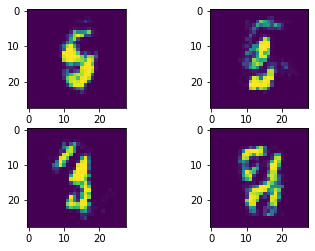

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.70it/s]


discrimnator loss  0.23536793385614443
generator loss  2.1964038834134687
Epoch [61 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

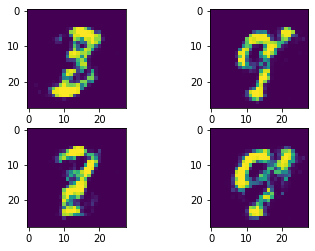

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.91it/s]

discrimnator loss  0.2613576618211864
generator loss  2.162708474883139
Epoch [62 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

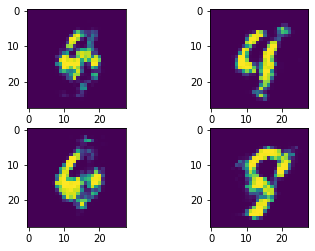

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.04it/s]

discrimnator loss  0.27495423229391397
generator loss  2.074768662961053
Epoch [63 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

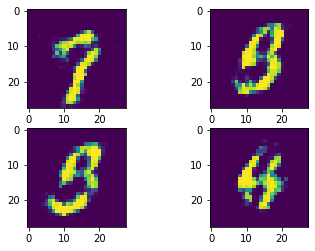

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:30<00:00, 15.18it/s]

discrimnator loss  0.25641085664981966
generator loss  2.133426966189321
Epoch [64 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

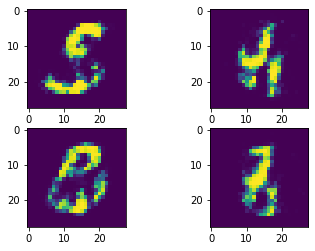

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.93it/s]


discrimnator loss  0.2718560993671418
generator loss  2.070394890140622
Epoch [65 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

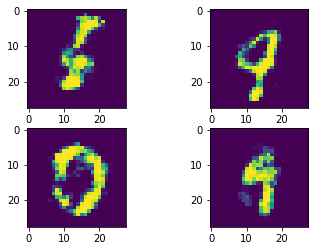

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.78it/s]


discrimnator loss  0.2498801588249612
generator loss  2.134051378347727
Epoch [66 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

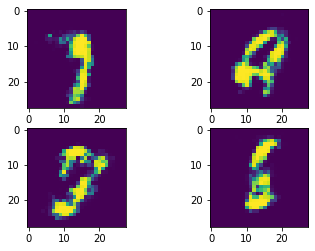

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.12it/s]

discrimnator loss  0.26686543464533574
generator loss  2.0583655963828553
Epoch [67 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

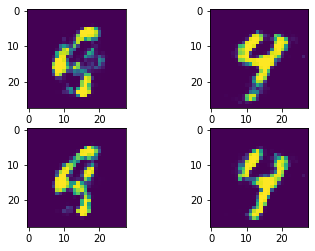

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.06it/s]


discrimnator loss  0.25554661182706523
generator loss  2.061441705170979
Epoch [68 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

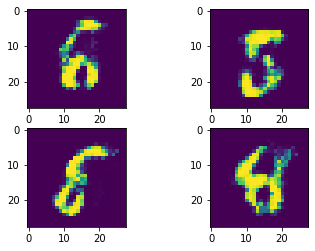

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.08it/s]

discrimnator loss  0.27593224710111686
generator loss  2.0826328286229914
Epoch [69 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

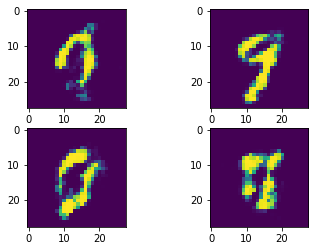

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:30<00:00, 15.13it/s]

discrimnator loss  0.2772313197856264
generator loss  2.0492887997678086
Epoch [70 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

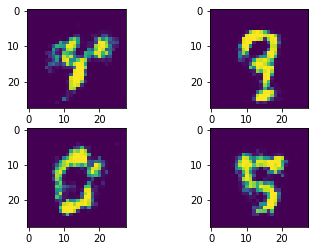

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.06it/s]

discrimnator loss  0.28530246902630546
generator loss  2.0304498217507465
Epoch [71 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

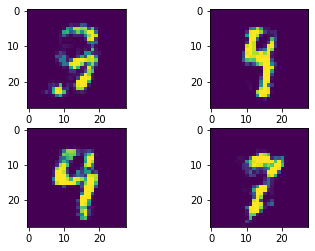

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.02it/s]


discrimnator loss  0.29585621285158964
generator loss  1.9968549615538704
Epoch [72 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

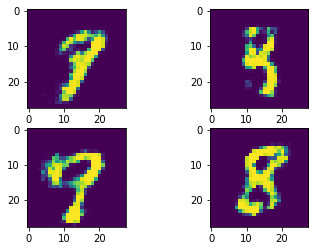

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.12it/s]


discrimnator loss  0.33123417217721324
generator loss  1.9153001572785862
Epoch [73 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

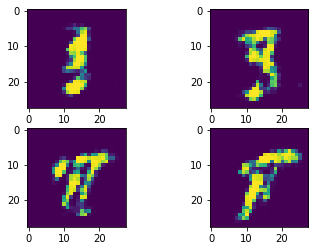

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.85it/s]

discrimnator loss  0.301377170788708
generator loss  1.993118348914676
Epoch [74 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

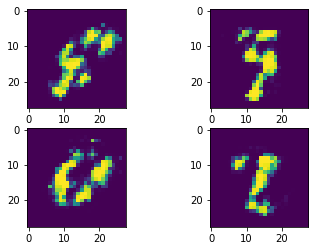

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.00it/s]


discrimnator loss  0.2979251128206374
generator loss  1.970417975616865
Epoch [75 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

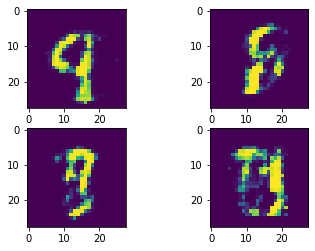

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.05it/s]


discrimnator loss  0.29774858362512047
generator loss  1.9741798283448853
Epoch [76 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

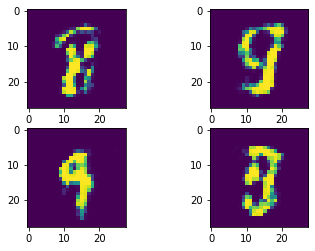

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.71it/s]


discrimnator loss  0.2966950702260553
generator loss  2.004726214957898
Epoch [77 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

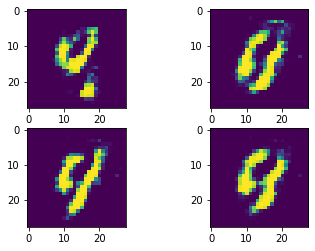

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.97it/s]


discrimnator loss  0.2834885012366372
generator loss  2.08654610332904
Epoch [78 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

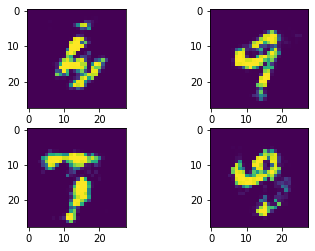

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.08it/s]

discrimnator loss  0.2955568887785807
generator loss  2.0425934860192907
Epoch [79 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

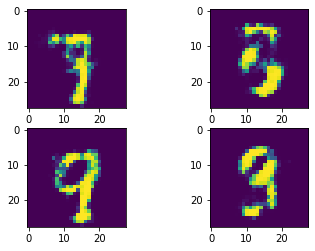

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.00it/s]

discrimnator loss  0.30656684502991055
generator loss  1.997337877623307
Epoch [80 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

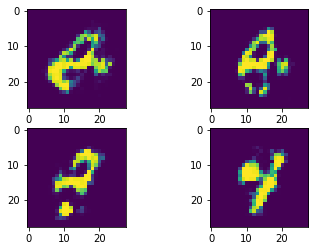

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.99it/s]


discrimnator loss  0.3237579441718713
generator loss  1.9100597103013153
Epoch [81 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

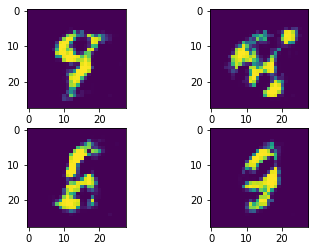

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.00it/s]


discrimnator loss  0.30670722667723593
generator loss  2.006897991908384
Epoch [82 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

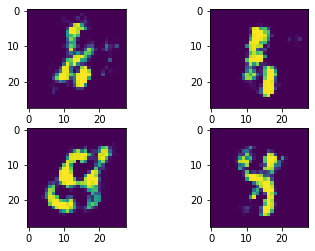

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.04it/s]


discrimnator loss  0.34953898331249694
generator loss  1.8964069873285205
Epoch [83 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

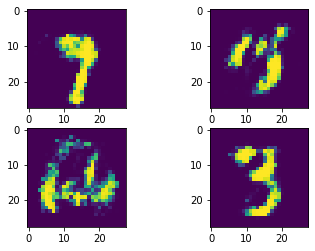

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.11it/s]


discrimnator loss  0.2998033379758602
generator loss  1.94007584408148
Epoch [84 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

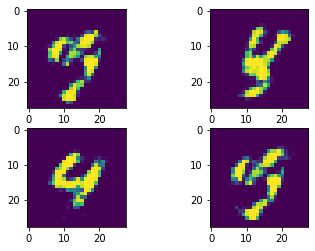

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.08it/s]

discrimnator loss  0.32058497504003536
generator loss  1.895273620385858
Epoch [85 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

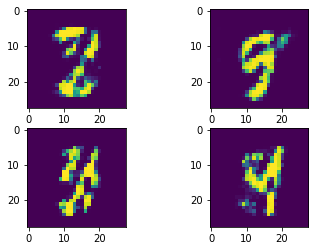

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.68it/s]


discrimnator loss  0.32148755025634884
generator loss  1.9653213303734767
Epoch [86 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

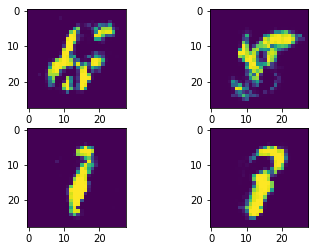

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.90it/s]

discrimnator loss  0.3273635068173602
generator loss  1.9268349800536873
Epoch [87 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

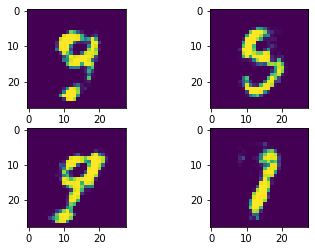

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.11it/s]

discrimnator loss  0.34438378683158305
generator loss  1.8855266746427477
Epoch [88 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

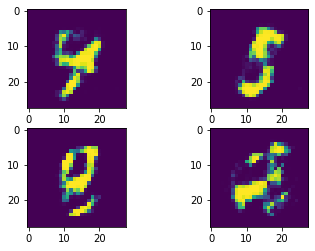

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.05it/s]


discrimnator loss  0.33646505947179167
generator loss  1.8629899713784652
Epoch [89 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

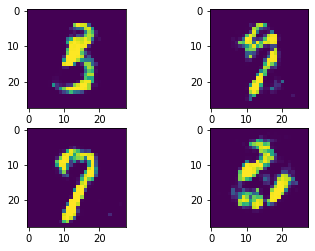

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.12it/s]


discrimnator loss  0.35346134140420354
generator loss  1.7998747929835361
Epoch [90 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

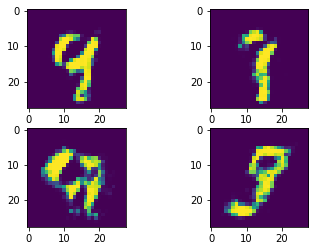

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:30<00:00, 15.17it/s]

discrimnator loss  0.3592623499220113
generator loss  1.8234257517592982
Epoch [91 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

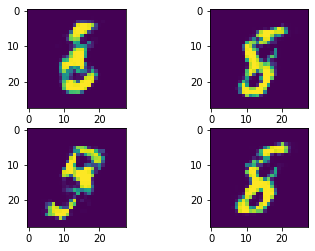

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:30<00:00, 15.28it/s]


discrimnator loss  0.36695524211377223
generator loss  1.7881378123500984
Epoch [92 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

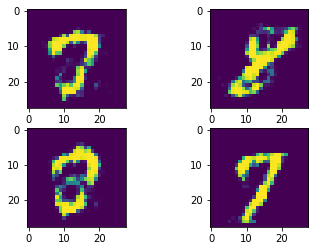

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.07it/s]

discrimnator loss  0.35109501273266025
generator loss  1.8442120676610012
Epoch [93 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

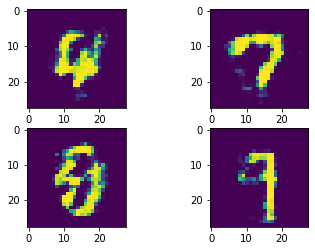

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.82it/s]


discrimnator loss  0.3539773853602947
generator loss  1.8006172998627625
Epoch [94 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

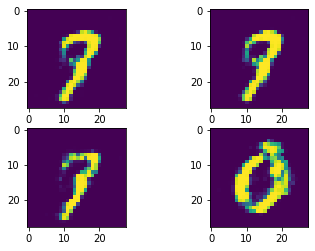

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.09it/s]

discrimnator loss  0.37658264451443735
generator loss  1.7592919490484802
Epoch [95 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

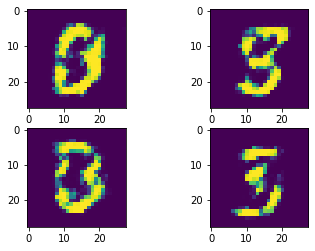

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.98it/s]


discrimnator loss  0.35753536802619235
generator loss  1.7939183907722356
Epoch [96 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

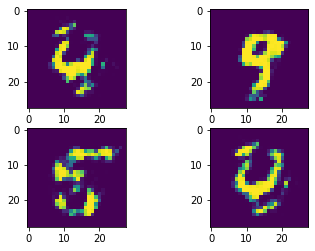

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.02it/s]


discrimnator loss  0.37588180198089916
generator loss  1.735235401053927
Epoch [97 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

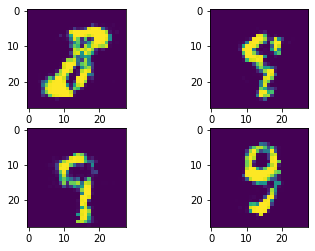

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 15.06it/s]

discrimnator loss  0.3640778842511208
generator loss  1.7807625616028877
Epoch [98 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

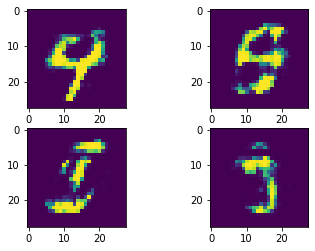

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:31<00:00, 14.99it/s]

discrimnator loss  0.33124102156426594
generator loss  1.8766790717395376
Epoch [99 / 100]
printing test images-->


<Figure size 432x288 with 0 Axes>

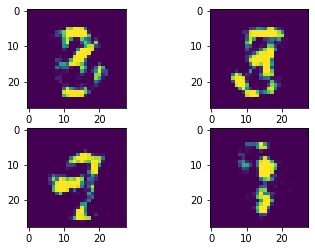

----------------------------


Train: 100%|█████████████████████████████| 469/469 [00:32<00:00, 14.56it/s]

discrimnator loss  0.34448340172960806
generator loss  1.884247028497235


In [21]:
for epoch in range(n_epochs):
    print(f"Epoch [{epoch} / {n_epochs}]")
    
    print("printing test images-->")
    images = generate_image(gen, 4, 64, "cuda")
    plot(images)
    print("----------------------------")
    mean_discriminator_loss, mean_generator_loss = Train(gen, disc, dataset, disc_opt, 
                                                         gen_opt, criterion)
    print("discrimnator loss ", mean_discriminator_loss)
    print("generator loss ", mean_generator_loss)

In [22]:
#save model
disc_path = "D:\\code\\deep learning\\torch\\gans\\my first gan\\save model\\gen\\best_model.pt"
gen_path= "D:\\code\\deep learning\\torch\\gans\\my first gan\\save model\\disc\\best_model.pt"

torch.save(gen.state_dict(), gen_path)
torch.save(disc.state_dict(), disc_path)

In [33]:
a = iter(dataset).next()[0][2][0]
a.shape

torch.Size([28, 28])

In [34]:
a.view(a.size(0), 784)
 

RuntimeError: shape '[28, 784]' is invalid for input of size 784

In [47]:
m.shape[]

torch.Size([8, 784])

In [51]:
get_noise(8, 64).shape

torch.Size([8, 64])

In [ ]:
gen()